In [1]:
import copy
import json
import torch
import torch.nn.utils.prune as prune
from torch import nn
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from vib_mlp_mnist_train import VIBNet, evaluate, MnistCsvDataset
from msc import plot_x_y, get_device, load_weights

In [2]:
torch.manual_seed(42)
device = get_device()
print(f'using device: {device}')

using device: cpu


In [7]:
dataset = MnistCsvDataset('data/mnist_data.csv')
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
batch_size = 100
print(f'train_size: {train_size}, test_size: {test_size}')

_, test_dataset = random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

betas = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
z_dim, h1, h2, o_shape = 75, 300, 100, 10

def weights_location(h1, h2, z_dim, beta):
    var = lambda v, w, x, y: f'vib_mnist_{v}_{w}_{x}_{y}'
    return f'save_stats_weights/{var(h1, h2, z_dim, beta)}/{var(h1, h2, z_dim, beta)}.pth'

train_size: 56000, test_size: 14000


In [86]:
layer_names = [
    #'fc1', 
    #'fc_mu',
    #'fc_logvar',
    'fc2',
    'fc_decode',
]

prune percs: [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


100%|████████████████████████████████████████████████████| 7/7 [00:15<00:00,  2.17s/it]


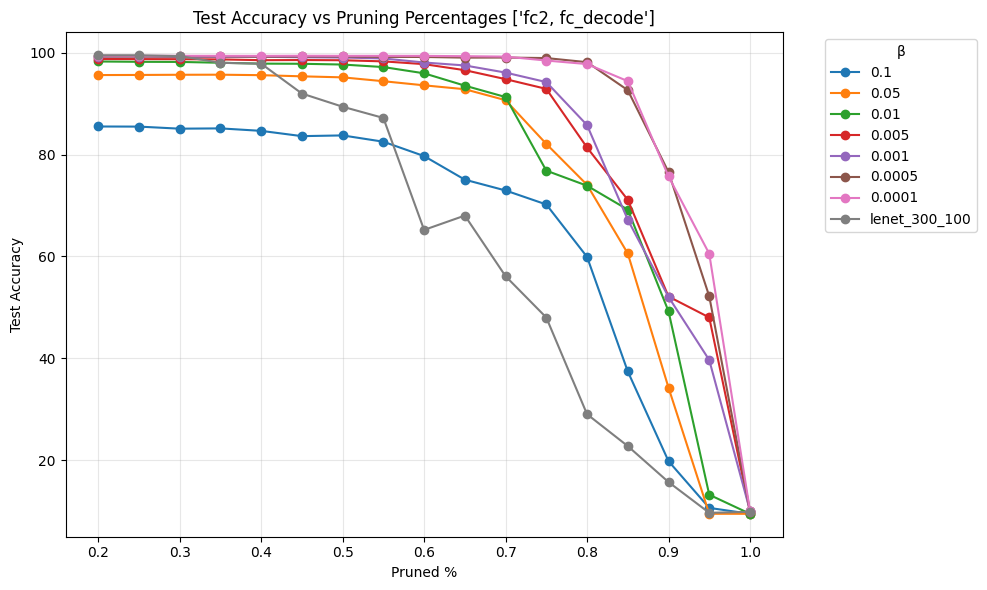

In [87]:
plt.figure(figsize=(10, 6))
prune_percs = [i/20 for i in range(4, 21)] 
print(f'prune percs: {prune_percs}')

for beta in tqdm(betas):
    model = VIBNet(z_dim, 784, h1, h2, o_shape).to(device)
    weights = load_weights(weights_location(h1, h2, z_dim, beta), verbose=False)
    model.load_state_dict(weights)
    pruned_acc_list = []
    for prune_perc in prune_percs:
        pruned_model = copy.deepcopy(model)
        for layer_name in layer_names:
            module = dict(pruned_model.named_modules())[layer_name]
            prune.l1_unstructured(module, name='weight', amount=prune_perc)
        
        test_loss, test_acc = evaluate(pruned_model, test_loader, device, beta=beta)
        pruned_acc_list.append(test_acc)
        
    plt.plot(prune_percs, pruned_acc_list, label=f'{beta}', marker='o')

from lenet_300_100_mnist import LeNet, evaluate as lenet_evaluate
lenet_model = LeNet()
lenet_weights = load_weights('save_stats_weights/lenet_300_100/lenet_300_100.pth', verbose=False)
lenet_model.load_state_dict(lenet_weights)
lenet_pruned_acc_list = []
for prune_perc in prune_percs:
    lenet_pruned_model = copy.deepcopy(lenet_model)
    for layer_name in layer_names:
        module = dict(lenet_pruned_model.named_modules())[layer_name]
        prune.l1_unstructured(module, name='weight', amount=prune_perc)

    criterion = nn.NLLLoss()
    test_loss, test_acc = lenet_evaluate(lenet_pruned_model, test_loader, criterion, device)
    lenet_pruned_acc_list.append(test_acc)
        
plt.plot(prune_percs, lenet_pruned_acc_list, label='lenet_300_100', marker='o')

plt.xlabel('Pruned %')
plt.ylabel('Test Accuracy')
plt.title(f"Test Accuracy vs Pruning Percentages ['{', '.join(layer_names)}']")
plt.legend(title='β', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/vib_mnist_beta_vs_pruned_acc_{'_'.join(layer_names)}.png", dpi=300, bbox_inches='tight')
plt.show()

100%|███████████████████████████████████████████████████| 7/7 [00:00<00:00, 365.15it/s]


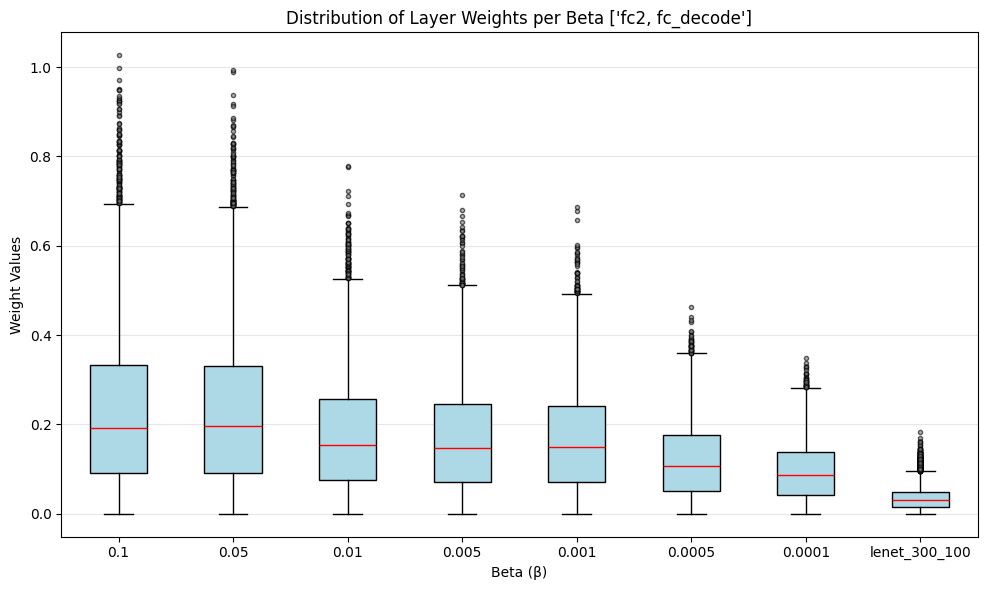

In [88]:
all_weights_by_beta = []
beta_labels = []
for beta in tqdm(betas):
    model = VIBNet(z_dim, 784, h1, h2, o_shape).to(device)
    weights = load_weights(weights_location(h1, h2, z_dim, beta), verbose=False)
    model.load_state_dict(weights)

    weight_values = []
    for layer_name in layer_names:
        module = dict(model.named_modules()).get(layer_name)
        if module is not None and hasattr(module, 'weight') and module.weight is not None:
            weight_values.append(module.weight.data.flatten())

    beta_tensor = torch.cat(weight_values)
    all_weights_by_beta.append(beta_tensor.abs().cpu().numpy())
    beta_labels.append(str(beta))

from lenet_300_100_mnist import LeNet, evaluate as lenet_evaluate
lenet_model = LeNet()
lenet_weights = load_weights('save_stats_weights/lenet_300_100/lenet_300_100.pth', verbose=False)
lenet_model.load_state_dict(lenet_weights)
weight_values = []
for layer_name in layer_names:
    module = dict(lenet_model.named_modules()).get(layer_name)
    if module is not None and hasattr(module, 'weight') and module.weight is not None:
        weight_values.append(module.weight.data.flatten())

beta_tensor = torch.cat(weight_values)
all_weights_by_beta.append(beta_tensor.abs().cpu().numpy())
beta_labels.append('lenet_300_100')

plt.figure(figsize=(10, 6))

plt.boxplot(
    all_weights_by_beta,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='black'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.6)
)

plt.xticks(ticks=range(1, len(beta_labels) + 1), labels=beta_labels, rotation=0)
plt.xlabel('Beta (β)')
plt.ylabel('Weight Values')
plt.title(f"Distribution of Layer Weights per Beta ['{', '.join(layer_names)}']")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/vib_mnist_beta_weight_dist_{'_'.join(layer_names)}.png", dpi=300, bbox_inches='tight')
plt.show()

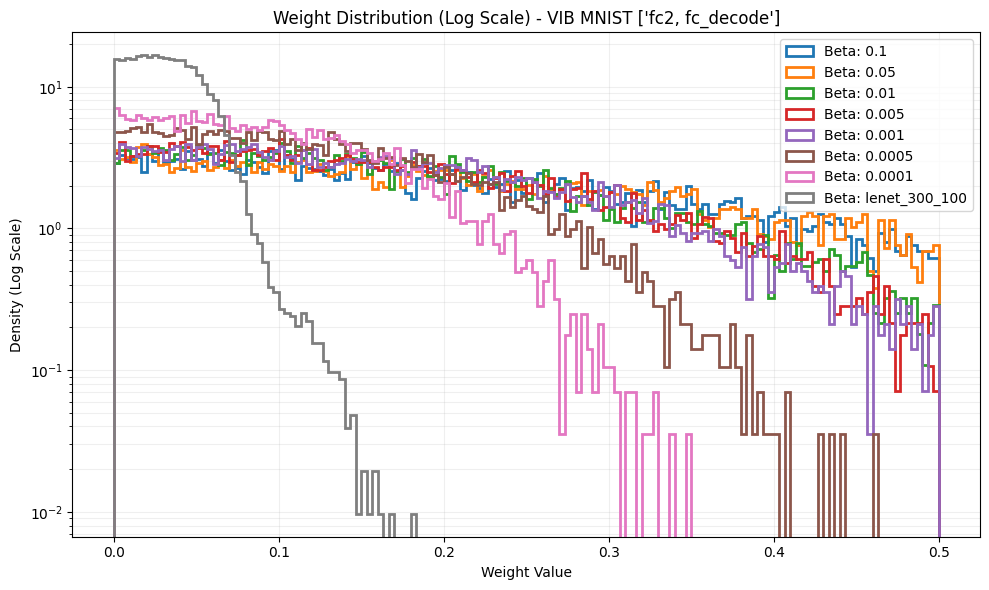

In [89]:
plt.figure(figsize=(10, 6))

for weights, label in zip(all_weights_by_beta, beta_labels):
    plt.hist(
        weights, 
        bins=150,
        range=(0, 0.5),
        density=True, # normalize so we compare shape, not raw counts
        histtype='step',
        linewidth=2, 
        label=f'Beta: {label}',
        log=True
    )

plt.xlabel('Weight Value')
plt.ylabel('Density (Log Scale)')
plt.title(f"Weight Distribution (Log Scale) - VIB MNIST ['{', '.join(layer_names)}']")
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-", alpha=0.2) # 'both' grids for log scale

plt.tight_layout()
plt.savefig(f"plots/vib_mnist_beta_weight_hist_{'_'.join(layer_names)}.png", dpi=300, bbox_inches='tight')
plt.show()